# Aria Inference Recipes

Here is an VLLM-version of the inference recipe, aiming to facilitate users with faster inference speed. 

## Section 4: (Long) Video Understanding (VLLM)

Aria is able to understand ver long videos with >100 frames as inputs. In this section, we show examples on several useful cases with its understanding ability on longer videos, as follows:

1. Summarizing a long video with details. 
2. Cutting a long video by scene transitions with timestamps.



### [General] Load Model and Processor

To maximize the actual length that Aria (VLLM version) can infer on a single 80GB GPU, we set the recommended parameter as follows:

- `max_model_len`: 38400
- `gpu_memory_utilization`: 0.84

This will allow a very long input with up to 64 high-resolution (980 resolution) or 256 mid-resolution (490 resolution) images to be fed as inputs of Aria with only one GPU, which will cover our long-context evaluation cases in Sections 3 and 4. Enjoy!

In [1]:
# load Aria model & tokenizer with vllm

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import requests
import torch
from PIL import Image

from transformers import AutoTokenizer
from vllm import LLM, SamplingParams


model_id_or_path = "rhymes-ai/Aria"

model = LLM(
        model=model_id_or_path,
        tokenizer=model_id_or_path,
        dtype="bfloat16",
        limit_mm_per_prompt={"image": 256},
        enforce_eager=True,
        trust_remote_code=True,
        max_model_len=38400,
        gpu_memory_utilization=0.84,
    )

tokenizer = AutoTokenizer.from_pretrained(
        model_id_or_path, trust_remote_code=True, use_fast=False
    )

/root/miniconda3/envs/aria/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-27 17:10:14,146	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 11-27 17:10:14 __init__.py:42] No plugins found.
INFO 11-27 17:10:16 config.py:1860] Downcasting torch.float32 to torch.bfloat16.
WARNING 11-27 17:10:24 arg_utils.py:1063] The model has a long context length (38400). This may cause OOM errors during the initial memory profiling phase, or result in low performance due to small KV cache space. Consider setting --max-model-len to a smaller value.
WARNING 11-27 17:10:24 config.py:527] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 11-27 17:10:24 llm_engine.py:248] Initializing an LLM engine (v0.6.4.post2.dev164+ge2251109) with config: model='rhymes-ai/Aria', speculative_config=None, tokenizer='rhymes-ai/Aria', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=38400, download_dir=None, load_format=LoadFormat.AUTO, tensor_p

Loading safetensors checkpoint shards:   0% Completed | 0/12 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:   8% Completed | 1/12 [00:03<00:41,  3.81s/it]
Loading safetensors checkpoint shards:  17% Completed | 2/12 [00:08<00:45,  4.57s/it]
Loading safetensors checkpoint shards:  25% Completed | 3/12 [00:12<00:37,  4.22s/it]
Loading safetensors checkpoint shards:  33% Completed | 4/12 [00:16<00:33,  4.24s/it]
Loading safetensors checkpoint shards:  42% Completed | 5/12 [00:20<00:28,  4.08s/it]
Loading safetensors checkpoint shards:  50% Completed | 6/12 [00:23<00:20,  3.47s/it]
Loading safetensors checkpoint shards:  58% Completed | 7/12 [00:28<00:20,  4.07s/it]
Loading safetensors checkpoint shards:  67% Completed | 8/12 [00:32<00:15,  3.93s/it]
Loading safetensors checkpoint shards:  75% Completed | 9/12 [00:35<00:11,  3.92s/it]
Loading safetensors checkpoint shards:  83% Completed | 10/12 [00:40<00:07,  3.99s/it]
Loading safetensors checkpoint shards:  92% Completed | 11/12

INFO 11-27 17:11:19 model_runner.py:1105] Loading model weights took 47.5600 GB
WARNING 11-27 17:11:19 model_runner.py:1284] Computed max_num_seqs (min(256, 38400 // 65536)) to be less than 1. Setting it to the minimum value of 1.
WARNING 11-27 17:11:19 fused_moe.py:326] Using default MoE config. Performance might be sub-optimal! Config file not found at /root/miniconda3/envs/aria/lib/python3.10/site-packages/vllm/model_executor/layers/fused_moe/configs/E=64,N=1664,device_name=NVIDIA_H100_80GB_HBM3.json
INFO 11-27 17:11:22 worker.py:236] Memory profiling results: duration=3.27 seconds, total_gpu_memory=79.11GiB, initial_memory_usage=47.98GiB, peak_torch_memory=50.71GiB, memory_usage_post_profile=48.05GiB, non_torch_memory=0.85GiB, kv_cache_size=14.89GiB, gpu_memory_utilization=0.84.
INFO 11-27 17:11:22 gpu_executor.py:76] # GPU blocks: 3485, # CPU blocks: 936
INFO 11-27 17:11:22 gpu_executor.py:80] Maximum concurrency for 38400 tokens per request: 1.45x


### Defining Functions to Load Video and Generate Placeholders

In the following codeblocks, we define the function to load a video to uniformly-sampled frames, and get placeholders for the video for Aria.

These functions can be called as follows:

```python
frames, frame_timestamps  = load_video(VIDEO_PATH, num_frames=NUM_FRAMES)



### If you want to insert timestamps for Aria Inputs
contents = get_placeholders_for_videos(frames, frame_timestamps)

### If you DO NOT want to insert frame timestamps for Aria Inputs
contents = get_placeholders_for_videos(frames)
```

Please see the examples as follows:


In [2]:
from decord import VideoReader
from PIL import Image
from tqdm import tqdm
from typing import List


def load_video(video_file, num_frames=128, cache_dir="cached_video_frames", verbosity="DEBUG"):
    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)

    video_basename = os.path.basename(video_file)
    cache_subdir = os.path.join(cache_dir, f"{video_basename}_{num_frames}")
    os.makedirs(cache_subdir, exist_ok=True)

    cached_frames = []
    missing_frames = []
    frame_indices = []
    
    for i in range(num_frames):
        frame_path = os.path.join(cache_subdir, f"frame_{i}.jpg")
        if os.path.exists(frame_path):
            cached_frames.append(frame_path)
        else:
            missing_frames.append(i)
            frame_indices.append(i) 
            
    vr = VideoReader(video_file)
    duration = len(vr)
    fps = vr.get_avg_fps()
            
    frame_timestamps = [int(duration / num_frames * (i+0.5)) / fps for i in range(num_frames)]
    
    if verbosity == "DEBUG":
        print("Already cached {}/{} frames for video {}, enjoy speed!".format(len(cached_frames), num_frames, video_file))
    # If all frames are cached, load them directly
    if not missing_frames:
        return [Image.open(frame_path).convert("RGB") for frame_path in cached_frames], frame_timestamps

    

    actual_frame_indices = [int(duration / num_frames * (i+0.5)) for i in missing_frames]


    missing_frames_data = vr.get_batch(actual_frame_indices).asnumpy()

    for idx, frame_index in enumerate(tqdm(missing_frames, desc="Caching rest frames")):
        img = Image.fromarray(missing_frames_data[idx]).convert("RGB")
        frame_path = os.path.join(cache_subdir, f"frame_{frame_index}.jpg")
        img.save(frame_path)
        cached_frames.append(frame_path)

    cached_frames.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    return [Image.open(frame_path).convert("RGB") for frame_path in cached_frames], frame_timestamps

def create_image_gallery(images, columns=3, spacing=20, bg_color=(200, 200, 200)):
    """
    Combine multiple images into a single larger image in a grid format.
    
    Parameters:
        image_paths (list of str): List of file paths to the images to display.
        columns (int): Number of columns in the gallery.
        spacing (int): Space (in pixels) between the images in the gallery.
        bg_color (tuple): Background color of the gallery (R, G, B).
    
    Returns:
        PIL.Image: A single combined image.
    """
    # Open all images and get their sizes
    img_width, img_height = images[0].size  # Assuming all images are of the same size

    # Calculate rows needed for the gallery
    rows = (len(images) + columns - 1) // columns

    # Calculate the size of the final gallery image
    gallery_width = columns * img_width + (columns - 1) * spacing
    gallery_height = rows * img_height + (rows - 1) * spacing

    # Create a new image with the calculated size and background color
    gallery_image = Image.new('RGB', (gallery_width, gallery_height), bg_color)

    # Paste each image into the gallery
    for index, img in enumerate(images):
        row = index // columns
        col = index % columns

        x = col * (img_width + spacing)
        y = row * (img_height + spacing)

        gallery_image.paste(img, (x, y))

    return gallery_image


def get_placeholders_for_videos(frames: List, timestamps=[]):
    contents = []
    if not timestamps:
        for i, _ in enumerate(frames):
            contents.append({"text": None, "type": "image"})
        contents.append({"text": "\n", "type": "text"})
    else:
        for i, (_, ts) in enumerate(zip(frames, timestamps)):
            contents.extend(
                [
                    {"text": f"[{int(ts)//60:02d}:{int(ts)%60:02d}]", "type": "text"},
                    {"text": None, "type": "image"},
                    {"text": "\n", "type": "text"}
                ]
            )
    return contents

### Task 1: Summarizing a Long Video with Details

In the first example, we pass a burger making recipes including multiple sub-recipes, and let Aria to provide a brief summarization on this recipe. This recipe lasts around 6 minutes, while we sample 128 uniform frames to cover most of its contents (at around 1/3 fps). Let's start our Aria video journey.

#### With 128 uniform frames

In [3]:
frames, frame_timestamps = load_video("visuals/wxWo44MoCTI.mp4", num_frames=128)

Already cached 0/128 frames for video visuals/wxWo44MoCTI.mp4, enjoy speed!


Caching rest frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 150.83it/s]


In [4]:
contents = get_placeholders_for_videos(frames, frame_timestamps)

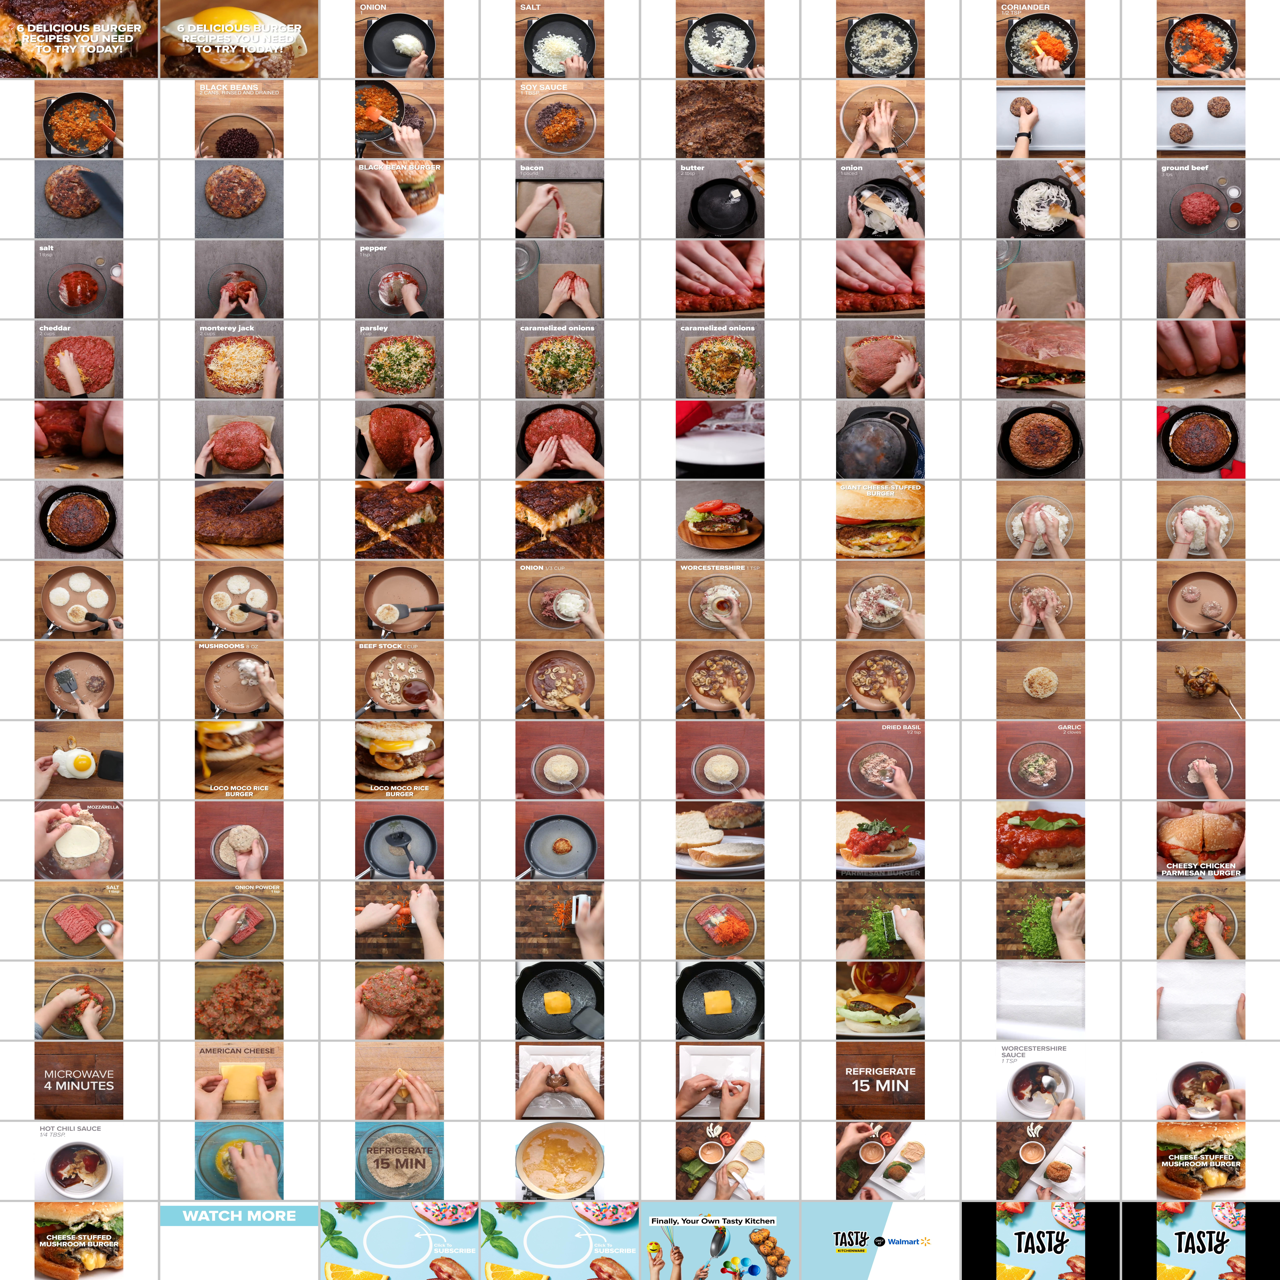

In [5]:
image_gallery = create_image_gallery(frames, columns=8)
display(image_gallery.resize((1280, 1280)))

In [6]:

messages = [
    {
        "role": "user",
        "content": [
            *contents,
            {"text": "This video has mentioned 6 burger recipes, but only 4 with names appear. Please list them, and briefly summarize how they are made.", "type": "text"},
        ],
    }
]

text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    outputs = model.generate(
            {
                "prompt_token_ids": text,
                "multi_modal_data": {
                    "image": frames,
                    "max_image_size": 490,  # [Optional] The max image patch size, default `980`
                    "split_image": False,  # [Optional] whether to split the images, default `False`
                },
            },
            sampling_params=SamplingParams(max_tokens=4096, top_k=1, stop=["<|im_end|>"])
        )
    generated_tokens = outputs[0].outputs[0].token_ids
    result = tokenizer.decode(generated_tokens)

print(result)

INFO 11-27 17:12:07 preprocess.py:215] Your model uses the legacy input pipeline instead of the new multi-modal processor. Please note that the legacy pipeline will be removed in a future release. For more details, see: https://github.com/vllm-project/vllm/issues/10114


/tmp/ipykernel_23566/3597555508.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
Processed prompts: 100%|███████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.24s/it, est. speed input: 1577.33 toks/s, output: 26.70 toks/s]

The video mentions six burger recipes, but only four are named. Here are the named burgers and a brief summary of their preparation:

1. **Black Bean Burger**:
   - **Preparation**: The process starts with sautéing onions and carrots, followed by adding black beans and seasonings. The mixture is combined and shaped into patties, which are then cooked on a griddle.

2. **Cheese-Stuffed Mushroom Burger**:
   - **Preparation**: The video shows the assembly of the burger, including placing cheese inside the mushroom cap and adding other toppings. The mushroom cap is then cooked until browned.

3. **Giant Cheese-Stuffed Burger**:
   - **Preparation**: This burger features a beef patty with a cheese filling, topped with a fried egg and other ingredients. The preparation involves forming the patty, adding cheese, and cooking it.

4. **Loco Moco Rice Burger**:
   - **Preparation**: The video shows the assembly of this burger, which includes a rice patty topped with a fried egg, mushrooms, and 

Similarly, we can also require a structured output for this.

In [7]:
from IPython.display import Markdown, display


messages = [
    {
        "role": "user",
        "content": [
            *contents,
            {"text": "This video has mentioned 6 burger recipes, but only 4 with names appear. Please list them, and summarize how they are made in details. Reply me with a structured output in JSON format.", "type": "text"},
        ],
    }
]

text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    outputs = model.generate(
            {
                "prompt_token_ids": text,
                "multi_modal_data": {
                    "image": frames,
                    "max_image_size": 490,  # [Optional] The max image patch size, default `980`
                    "split_image": False,  # [Optional] whether to split the images, default `False`
                },
            },
            sampling_params=SamplingParams(max_tokens=4096, top_k=1, stop=["<|im_end|>"])
        )
    generated_tokens = outputs[0].outputs[0].token_ids
    result = tokenizer.decode(generated_tokens)

display(Markdown(result))

/tmp/ipykernel_23566/2720790643.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
Processed prompts: 100%|███████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.58s/it, est. speed input: 1531.21 toks/s, output: 30.74 toks/s]


```json
{
  "burger_recipes": [
    {
      "name": "Black Bean Burger",
      "summary": "The video shows the preparation of a black bean burger. It starts with sautéing onions and carrots, then adding black beans and seasonings. The mixture is combined and shaped into patties, which are cooked on a griddle. The final product is a black bean burger served on a bun with toppings."
    },
    {
      "name": "Giant Cheese-Stuffed Burger",
      "summary": "The video demonstrates the preparation of a giant cheese-stuffed burger. It involves forming a beef patty around a mozzarella cheese center, cooking it, and assembling it into a burger with buns and toppings."
    },
    {
      "name": "Loco Moco Rice Burger",
      "summary": "The video illustrates the making of a loco moco rice burger. It includes forming rice patties, cooking them, and topping them with a fried egg, mushrooms, and cheese. The final assembly includes placing the rice patty on a bun."
    },
    {
      "name": "Cheesy Chicken Parmesan Burger",
      "summary": "The video shows the preparation of a cheesy chicken parmesan burger. It involves forming a chicken patty, adding cheese, and cooking it. The final assembly includes placing the chicken patty on a bun with marinara sauce and basil."
    }
  ]
}
```<|im_end|>

#### With 384 uniform frames

In the previous examples, we have noticed that there are only four burger names appearing in the sampled frames, though this video actually includes a recipe of 6 burgers. While we watch and check the video, we confirmt that there are still two burgers with names appearing and disappearing very fast, resulting that **frames with their names are still not sampled**. 

Therefore, we directly increase to sample 256 frames for this video (at about 0.67fps), and see whether more burger names can appear, and more importantly, still captured by the Aria model.

In [8]:
frames, frame_timestamps = load_video("visuals/wxWo44MoCTI.mp4", num_frames=256)
contents = get_placeholders_for_videos(frames, frame_timestamps)

Already cached 0/256 frames for video visuals/wxWo44MoCTI.mp4, enjoy speed!


Caching rest frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 134.60it/s]


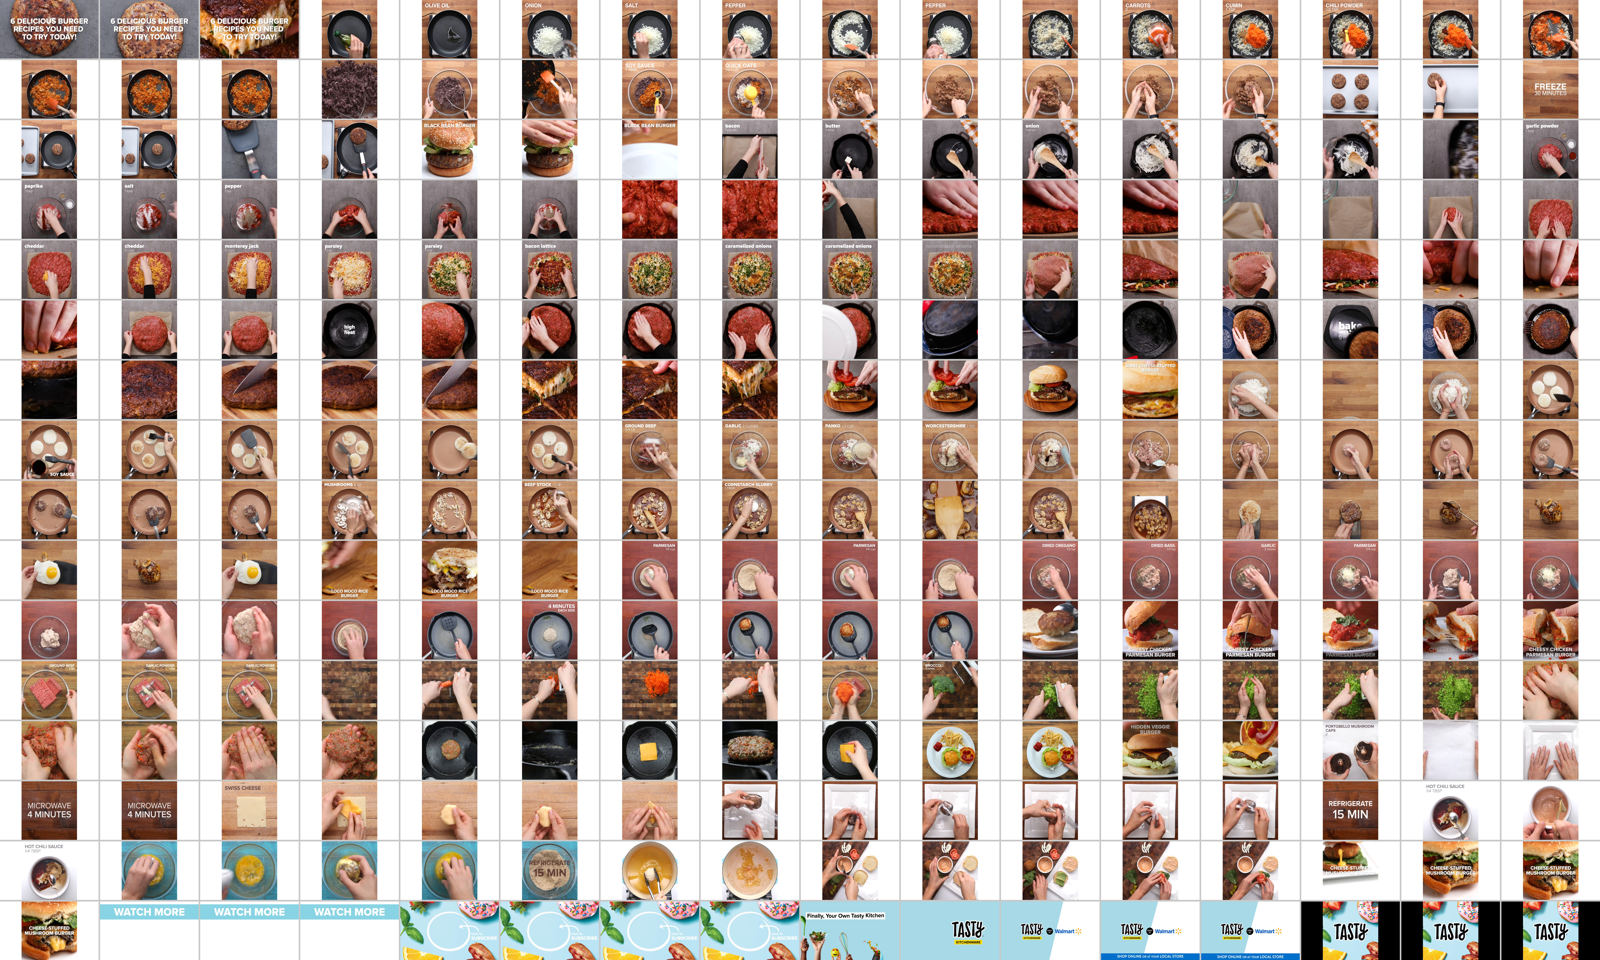

In [9]:
image_gallery = create_image_gallery(frames, columns=16)
display(image_gallery.resize((1600, 960)))

In [10]:
torch.cuda.empty_cache()

messages = [
    {
        "role": "user",
        "content": [
            *contents,
            {"text": "Please list the burgers that appear in this video, and how they are made.", "type": "text"},
        ],
    }
]

text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    outputs = model.generate(
            {
                "prompt_token_ids": text,
                "multi_modal_data": {
                    "image": frames,
                    "max_image_size": 490,  # [Optional] The max image patch size, default `980`
                    "split_image": False,  # [Optional] whether to split the images, default `False`
                },
            },
            sampling_params=SamplingParams(max_tokens=4096, top_k=1, stop=["<|im_end|>"])
        )
    generated_tokens = outputs[0].outputs[0].token_ids
    result = tokenizer.decode(generated_tokens)

print(result)

/tmp/ipykernel_23566/1150943341.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
Processed prompts: 100%|███████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.00s/it, est. speed input: 2210.18 toks/s, output: 28.49 toks/s]

The video showcases the following burgers and their preparation methods:

1. **Black Bean Burger**
   - **Preparation**:
     - Mix ground beef with spices (garlic powder, paprika, salt, pepper).
     - Form into patties and cook in a skillet.
     - Serve on a bun with toppings like avocado and tomato.

2. **Cheese-Stuffed Mushroom Burger**
   - **Preparation**:
     - Prepare patties with ground beef and spices.
     - Stuff with cheese and mushrooms.
     - Cook in a skillet until browned.
     - Serve on a bun with melted cheese and vegetables.

3. **Cheesy Chicken Parmesan Burger**
   - **Preparation**:
     - Form chicken mixture into patties.
     - Cook in a skillet until browned.
     - Top with marinara sauce and melted cheese.
     - Serve on a bun.

4. **Hidden Veggie Burger**
   - **Preparation**:
     - Mix ground beef with grated vegetables (carrots, broccoli).
     - Form into patties and cook in a skillet.
     - Serve on a bun with lettuce and tomato.

5. **Giant Chee

#### Summary

With twice frames sampled, this time we finally get the name of the fifth burger, **Giant Cheese-Stuffed Burger**. However, these frames (see the gallery above) still do not include the sixth burger's name (which is **Hidden Veggie Burger**, as we have really watched this video from start to end). 

This 'non-perfect' case has shown that a model that is able to alloow more frames as inputs are ***more useful than we all can expect***; 

On the other hand, with more frames (256 vs 128) fed into the model, Aria is capable of extracting the additional burger name that appears in the middle of the video, while summarizing the recipe for the appeared five burgers very effectively. 

We hope this exciting ability can allow Aria a new landmark for open-source LMMs on long video understanding, and inspire many new application scenarios.

### Task 2: Splitting a Long Video into Scenes (with Timestamps)

With timestamps interleaved with frames as Aria Inputs, we can do some more interesting tasks, for instance, split a video into multiple segments, and label their starting and ending timestamps. This is very useful for long videos to understand their structures, and can directly benefit watchers (who can directly watch the 'scenes-of-interest'). We show the example as follows.

In [11]:
frames, frame_timestamps = load_video("visuals/QdlP8ai8trw.mp4", num_frames=128)
contents = get_placeholders_for_videos(frames, frame_timestamps)

Already cached 0/128 frames for video visuals/QdlP8ai8trw.mp4, enjoy speed!


Caching rest frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 142.25it/s]


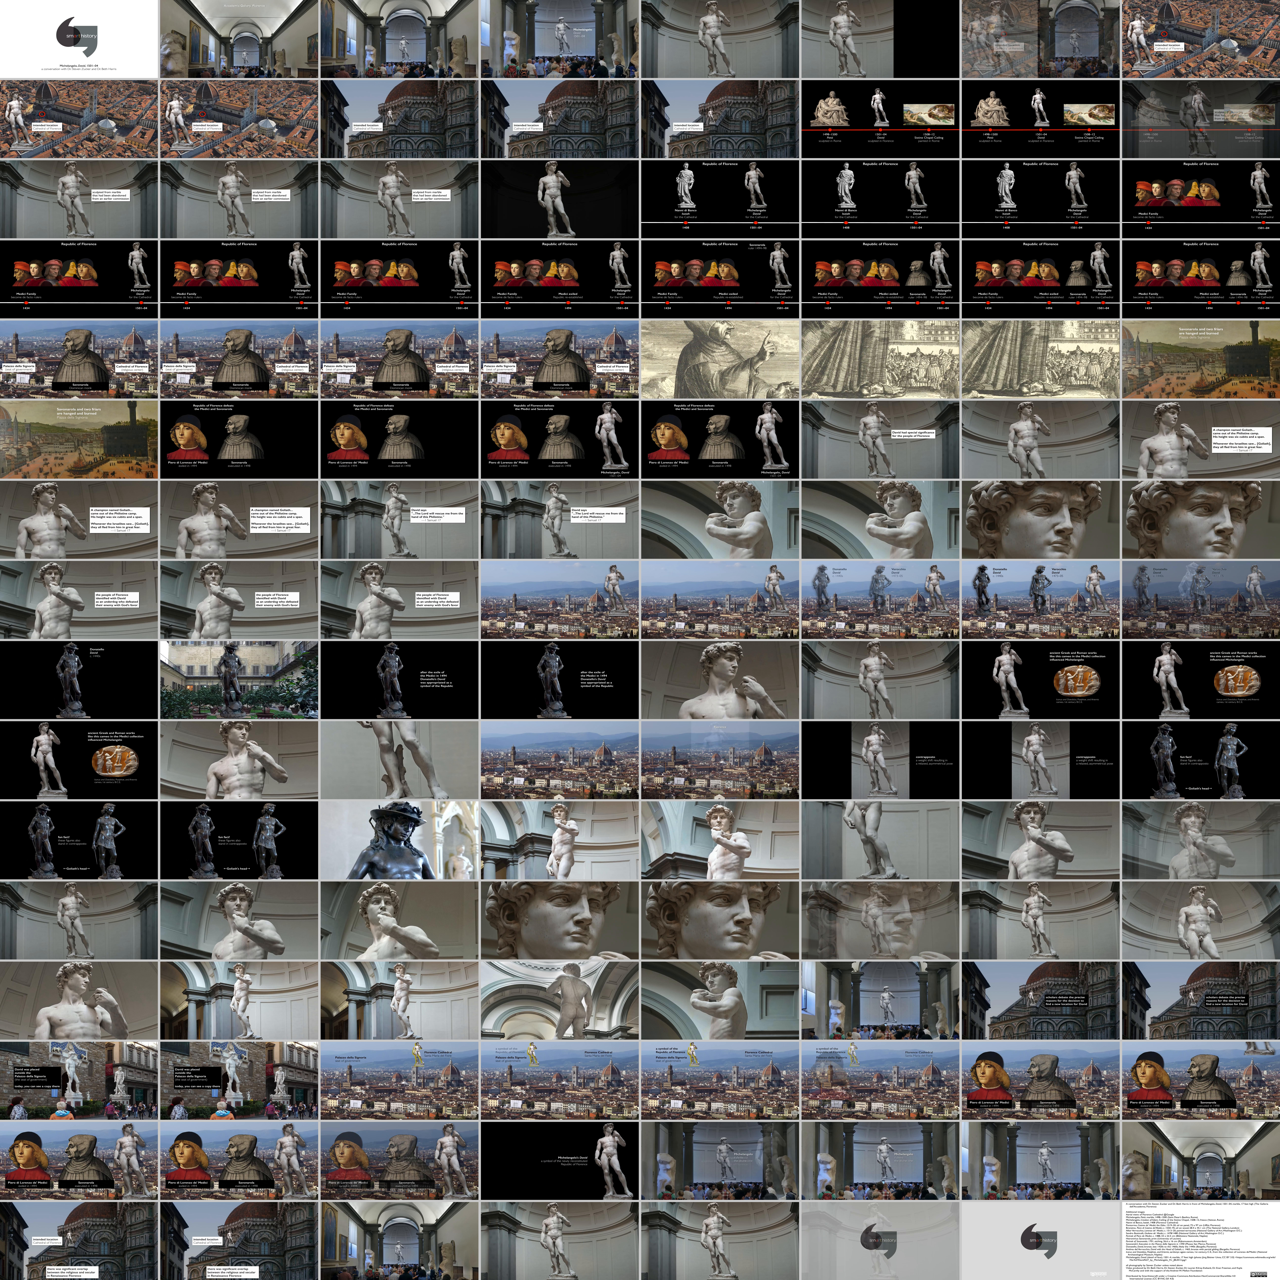

In [12]:
image_gallery = create_image_gallery(frames, columns=8)
display(image_gallery.resize((1280, 1280)))

In [13]:
torch.cuda.empty_cache()

messages = [
    {
        "role": "user",
        "content": [
            *contents,
            {"text": "Please split this video into scenes, providing start time, end time, a title and detailed descriptions for each scene.", "type": "text"},
        ],
    }
]

text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    outputs = model.generate(
            {
                "prompt_token_ids": text,
                "multi_modal_data": {
                    "image": frames,
                    "max_image_size": 490,  # [Optional] The max image patch size, default `980`
                    "split_image": False,  # [Optional] whether to split the images, default `False`
                },
            },
            sampling_params=SamplingParams(max_tokens=4096, top_k=1, stop=["<|im_end|>"])
        )
    generated_tokens = outputs[0].outputs[0].token_ids
    result = tokenizer.decode(generated_tokens)

print(result)

/tmp/ipykernel_23566/103968052.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
Processed prompts: 100%|████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.46s/it, est. speed input: 283.58 toks/s, output: 33.36 toks/s]

Here is a detailed breakdown of the video scenes:

1. **Scene 1: Introduction**
   - **Start Time:** 00:01
   - **End Time:** 00:05
   - **Title:** Introduction
   - **Description:** The video opens with a title screen featuring the 'smarthistory' logo and the text 'Michelangelo, David, 1501-04,' indicating a conversation with Dr. Steven Zucker and Dr. Beth Harris.

2. **Scene 2: Accademia Gallery, Florence**
   - **Start Time:** 00:05
   - **End Time:** 00:40
   - **Title:** Accademia Gallery, Florence
   - **Description:** The scene transitions to the interior of the Accademia Gallery in Florence, showcasing Michelangelo's David statue. The gallery is bustling with visitors, and the statue is prominently displayed.

3. **Scene 3: Historical Context**
   - **Start Time:** 00:40
   - **End Time:** 01:08
   - **Title:** Historical Context
   - **Description:** The scene shifts to a timeline highlighting significant artworks and events, including Michelangelo's David and the Sistine Chap